In [1]:
!pip install git+https://github.com/anudeep-23042002/keras-vggface.git

  Cloning https://github.com/anudeep-23042002/keras-vggface.git to /tmp/pip-req-build-zi01dyps
  Running command git clone --filter=blob:none --quiet https://github.com/anudeep-23042002/keras-vggface.git /tmp/pip-req-build-zi01dyps
  Resolved https://github.com/anudeep-23042002/keras-vggface.git to commit 5cd56fc6520071f1dd0080959450740dabae72af
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8334 sha256=b3a193b9a89e00bb014482aba9752f6d7d6733088c682cca5c7a98e9af721c17
  Stored in directory: /tmp/pip-ephem-wheel-cache-louxv8it/wheels/f8/10/5c/05f53f02d55e7ccb5852197e256aefe3c323c06e68f9c7c820
Successfully built keras-vggface


In [2]:
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D

import pydot

In [4]:
import shutil
import os

path = ["/kaggle/working/train/Angry",
      "/kaggle/working/train/Disgust",
      "/kaggle/working/train/Fear",
      "/kaggle/working/train/Happy",
      "/kaggle/working/train/Sad",

      "/kaggle/working/train/Surprise",
      "/kaggle/working/train/Neutral",
      "/kaggle/working/val/Angry",
      "/kaggle/working/val/Disgust",
      "/kaggle/working/val/Fear",
      "/kaggle/working/val/Happy",
      "/kaggle/working/val/Sad",
      "/kaggle/working/val/Surprise",
      "/kaggle/working/val/Neutral",
      "/kaggle/working/test/Angry",
      "/kaggle/working/test/Disgust",
      "/kaggle/working/test/Fear",
      "/kaggle/working/test/Happy",
      "/kaggle/working/test/Sad",
      "/kaggle/working/test/Surprise",
      "/kaggle/working/test/Neutral"]

for folder_path in path:
    # Check if the folder exists
            # If the folder exists, remove it and its contents
        try:
            os.makedirs(folder_path)
        except OSError:
            try:
                shutil.rmtree(folder_path)
                os.makedirs(folder_path)
            except OSError as e:
                print(f"Error: {e}")


In [5]:
from PIL import Image

emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
classes = list(map(lambda x: emotions[x], emotions))

data = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')
# Print or use the mapped_emotions list as needed
print(classes)
for i, row in data.iterrows():
    emotion = row['emotion']
    pixels = np.fromstring(row[' pixels'], dtype=int, sep=' ')
    image_array = np.reshape(pixels, (48, 48))

    # Convert the NumPy array to an image
    image = Image.fromarray(image_array.astype('uint8'))
    if(row[' Usage']=="Training"):
    # Create a folder (if not exists) based on the emotion
        folder_path = f'/kaggle/working/train/{emotions[emotion]}/'
    elif (row[' Usage']=="PublicTest"):
        folder_path = f'/kaggle/working/test/{emotions[emotion]}/'
    else:
        folder_path = f'/kaggle/working/val/{emotions[emotion]}/'
    # Save the image to the folder
    image.save(os.path.join(folder_path, f'image_{i}.png'))

print("Images saved to the folder.")

['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
Images saved to the folder.


In [6]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [7]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(2048, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc8')(x)
x = Dropout(DROPOUT_RATE)(x)
# l=0
# for layer in vgg_notop.layers:
#     print(layer,"["+str(l)+"]")
#     l=l+1
    
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False
# print('vgg layer 2 is trainable: ' + str(vgg_notop.layers[2].trainable))
# print('vgg layer 3 is trainable: ' + str(vgg_notop.layers[3].trainable))

out = Dense(7, activation='softmax', name='classifier')(x)

model = tf.keras.Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=5, min_lr=0.00001, verbose=1)
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
# plot_model(model, to_file='model2.png', show_shapes=True)

94694792/94694792 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [9]:
train_generator  = get_datagen('/kaggle/working/train', True)
dev_generator    = get_datagen('/kaggle/working/test')
val_generator    = get_datagen('/kaggle/working/val')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [11]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=len(train_generator),
    validation_steps=len(dev_generator),
    shuffle=True,
    epochs=100,
    callbacks=[rlrop],
    use_multiprocessing=True,
) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == "__main__":


Epoch 1/100
225/225 [==============================] - 315s 1s/step - loss: 1.8514 - accuracy: 0.3874 - val_loss: 2.0126 - val_accuracy: 0.1691 - lr: 0.0010
Epoch 2/100
225/225 [==============================] - 308s 1s/step - loss: 1.2193 - accuracy: 0.5468 - val_loss: 1.8833 - val_accuracy: 0.1708 - lr: 0.0010
Epoch 3/100
225/225 [==============================] - 307s 1s/step - loss: 1.1315 - accuracy: 0.5863 - val_loss: 1.3341 - val_accuracy: 0.4870 - lr: 0.0010
Epoch 4/100
225/225 [==============================] - 298s 1s/step - loss: 1.0859 - accuracy: 0.6012 - val_loss: 1.0639 - val_accuracy: 0.6096 - lr: 0.0010
Epoch 5/100
225/225 [==============================] - 297s 1s/step - loss: 1.0470 - accuracy: 0.6160 - val_loss: 1.0039 - val_accuracy: 0.6350 - lr: 0.0010
Epoch 6/100
225/225 [==============================] - 305s 1s/step - loss: 1.0254 - accuracy: 0.6294 - val_loss: 0.9867 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 7/100
225/225 [==============================] - 296

In [12]:
Y_pred = model.predict(dev_generator)
y_pred = np.argmax(Y_pred, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [13]:
cm = confusion_matrix(dev_generator.classes, y_pred)
print(confusion_matrix(dev_generator.classes, y_pred))
print('Classification Report')
target_names = ['1','2','3','4','5','6','7']
print(classification_report(dev_generator.classes, y_pred, target_names=target_names))

[[ 61  11  66 121  76  83  49]
 [  4   0   4  14  18  11   5]
 [ 56   5  41 143  85 108  58]
 [128   9  76 237 165 187  93]
 [ 67   6  64 165 122 116  67]
 [101   6  61 163 125 125  72]
 [ 51   4  54  93  78  82  53]]
Classification Report
              precision    recall  f1-score   support

           1       0.13      0.13      0.13       467
           2       0.00      0.00      0.00        56
           3       0.11      0.08      0.10       496
           4       0.25      0.26      0.26       895
           5       0.18      0.20      0.19       607
           6       0.18      0.19      0.18       653
           7       0.13      0.13      0.13       415

    accuracy                           0.18      3589
   macro avg       0.14      0.14      0.14      3589
weighted avg       0.17      0.18      0.18      3589



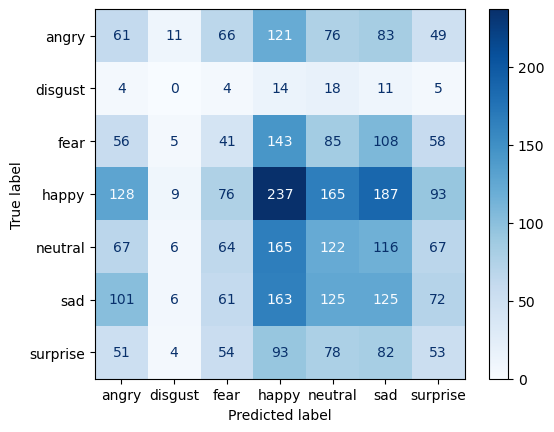

In [14]:
labels=['angry','disgust','fear','happy','neutral','sad','surprise']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [65]:
print('\n# Evaluate on test data')
results_test = model.evaluate(val_generator)
print('test loss, test acc:', results_test)


# Evaluate on test data
29/29 [==============================] - 6s 195ms/step - loss: 0.8554 - accuracy: 0.7197
test loss, test acc: [0.8553675413131714, 0.7196990847587585]


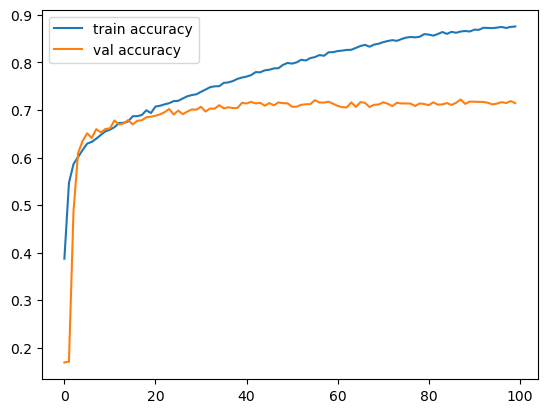

In [16]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

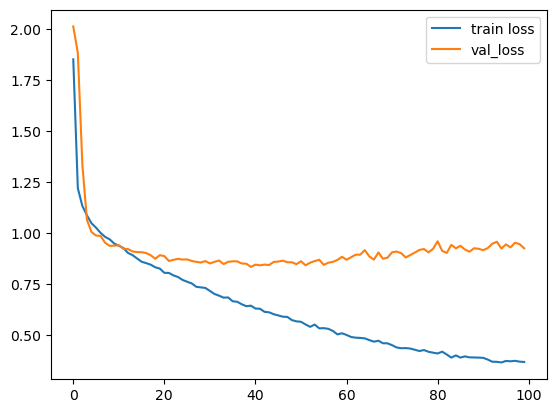

In [17]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

In [18]:
Y_pred = model.predict(dev_generator)
y_pred = np.argmax(Y_pred, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
model.save('/kaggle/working/model_1.h5')
model.save('./model_1.h5')

Inference in FER2013

/kaggle/working/train/Neutral/image_2406.png
1/1 [==============================] - 1s 843ms/step


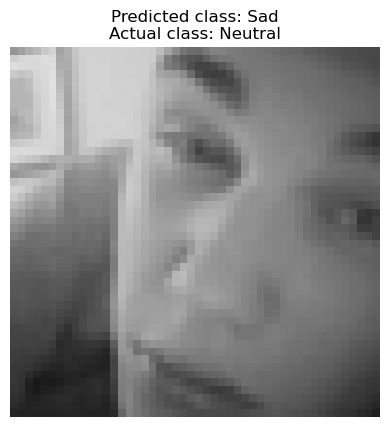

Predicted class: Sad
Actual class: Neutral


In [41]:
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Set the path to your model
model_path = '/kaggle/working/model.h5'
model = load_model(model_path)

# Define the base directory where your images are stored
base_dir = '/kaggle/working/'

# List all the classes
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(197, 197))
    
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to get a random image path from a directory
def get_random_image_path(directory):
    class_folder = random.choice(os.listdir(directory))
    class_path = os.path.join(directory, class_folder)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    return img_path

# Get a random image path from the training directory
img_path = get_random_image_path(os.path.join(base_dir, random.choice(['train','test','val'])))
print(img_path)
# Load and preprocess the image
img_array = load_and_preprocess_image(img_path)

# Make predictions using the loaded model
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = classes[np.argmax(predictions)]
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}\nActual class: {img_path.split('/')[-2]}")
plt.axis('off')
plt.show()
print(f"Predicted class: {predicted_class}")
print(f"Actual class: {img_path.split('/')[-2]}")


Inference on random images

In [53]:
!wget https://cdn1.tuoitre.vn/zoom/600_315/471584752817336320/2023/8/13/f3xiqfpw4aeo-vo-1691881627442514206495-275-0-1174-1718-crop-16918816519171461578928.jpg

--2024-01-20 13:51:37--  https://cdn1.tuoitre.vn/zoom/600_315/471584752817336320/2023/8/13/f3xiqfpw4aeo-vo-1691881627442514206495-275-0-1174-1718-crop-16918816519171461578928.jpg
Resolving cdn1.tuoitre.vn (cdn1.tuoitre.vn)... 123.30.242.10, 42.112.37.34, 42.112.37.35, ...
Connecting to cdn1.tuoitre.vn (cdn1.tuoitre.vn)|123.30.242.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66300 (65K) [image/jpeg]
Saving to: ‘f3xiqfpw4aeo-vo-1691881627442514206495-275-0-1174-1718-crop-16918816519171461578928.jpg’

f3xiqfpw4aeo-vo-169 100%[===================>]  64.75K   225KB/s    in 0.3s    

2024-01-20 13:51:38 (225 KB/s) - ‘f3xiqfpw4aeo-vo-1691881627442514206495-275-0-1174-1718-crop-16918816519171461578928.jpg’ saved [66300/66300]



/kaggle/working/f3xiqfpw4aeo-vo-1691881627442514206495-275-0-1174-1718-crop-16918816519171461578928.jpg
1/1 [==============================] - 1s 972ms/step


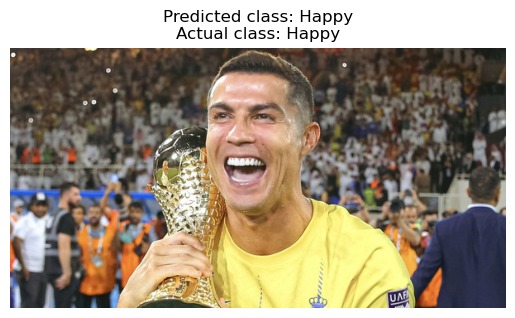

Predicted class: Happy
Actual class: Happy


In [54]:
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Set the path to your model
model_path = '/kaggle/working/model_1.h5'
model = load_model(model_path)

# Define the base directory where your images are stored
base_dir = '/kaggle/working/'

# List all the classes
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(197, 197))
    
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to get a random image path from a directory
def get_random_image_path(directory):
    class_folder = random.choice(os.listdir(directory))
    class_path = os.path.join(directory, class_folder)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    return img_path

# Get a random image path from the training directory
img_path = "/kaggle/working/f3xiqfpw4aeo-vo-1691881627442514206495-275-0-1174-1718-crop-16918816519171461578928.jpg"
print(img_path)
# Load and preprocess the image
img_array = load_and_preprocess_image(img_path)

# Make predictions using the loaded model
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = classes[np.argmax(predictions)]
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}\nActual class: Happy")
plt.axis('off')
plt.show()
print(f"Predicted class: {predicted_class}")
print(f"Actual class: Happy")

In [55]:
!wget https://www.aljazeera.com/wp-content/uploads/2022/12/SSS10784_1.jpg?resize=1800%2C1800

--2024-01-20 13:53:52--  https://www.aljazeera.com/wp-content/uploads/2022/12/SSS10784_1.jpg?resize=1800%2C1800
Resolving www.aljazeera.com (www.aljazeera.com)... 184.24.254.69, 2600:1415:3c00:28f::2392, 2600:1415:3c00:293::2392
Connecting to www.aljazeera.com (www.aljazeera.com)|184.24.254.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405183 (396K) [image/jpeg]
Saving to: ‘SSS10784_1.jpg?resize=1800,1800’

SSS10784_1.jpg?resi 100%[===================>] 395.69K  --.-KB/s    in 0.009s  

2024-01-20 13:53:52 (40.9 MB/s) - ‘SSS10784_1.jpg?resize=1800,1800’ saved [405183/405183]



/kaggle/working/SSS10784_1.jpg?resize=1800,1800
1/1 [==============================] - 1s 975ms/step


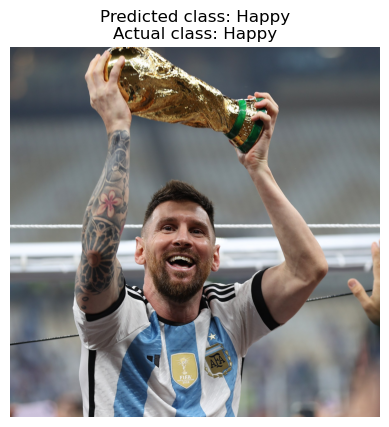

Predicted class: Happy
Actual class: Happy


In [56]:
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Set the path to your model
model_path = '/kaggle/working/model_1.h5'
model = load_model(model_path)

# Define the base directory where your images are stored
base_dir = '/kaggle/working/'

# List all the classes
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(197, 197))
    
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to get a random image path from a directory
def get_random_image_path(directory):
    class_folder = random.choice(os.listdir(directory))
    class_path = os.path.join(directory, class_folder)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    return img_path

# Get a random image path from the training directory
img_path = "/kaggle/working/SSS10784_1.jpg?resize=1800,1800"
print(img_path)
# Load and preprocess the image
img_array = load_and_preprocess_image(img_path)

# Make predictions using the loaded model
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = classes[np.argmax(predictions)]
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}\nActual class: Happy")
plt.axis('off')
plt.show()
print(f"Predicted class: {predicted_class}")
print(f"Actual class: Happy")